In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('data/01_input_history.csv')
print(df.shape)
df['ds'] = pd.to_datetime(df['Month'], format='%b%Y')
df['unique_id'] = df['Country'] + '_' + df['Product']
df.head()

(240000, 4)


,Country,Product,Month,Quantity,ds,unique_id
0,Japan,MorningMint,Jan2004,0,2004-01-01,Japan_MorningMint
1,Japan,MorningMint,Feb2004,0,2004-02-01,Japan_MorningMint
2,Japan,MorningMint,Mar2004,0,2004-03-01,Japan_MorningMint
3,Japan,MorningMint,Apr2004,0,2004-04-01,Japan_MorningMint
4,Japan,MorningMint,May2004,0,2004-05-01,Japan_MorningMint


In [8]:
print(f" Number of countries: {len(df['Country'].unique())}")
print(f" Number of product: {len(df['Product'].unique())}")


 Number of countries: 10
 Number of product: 100


In [22]:
# pre process

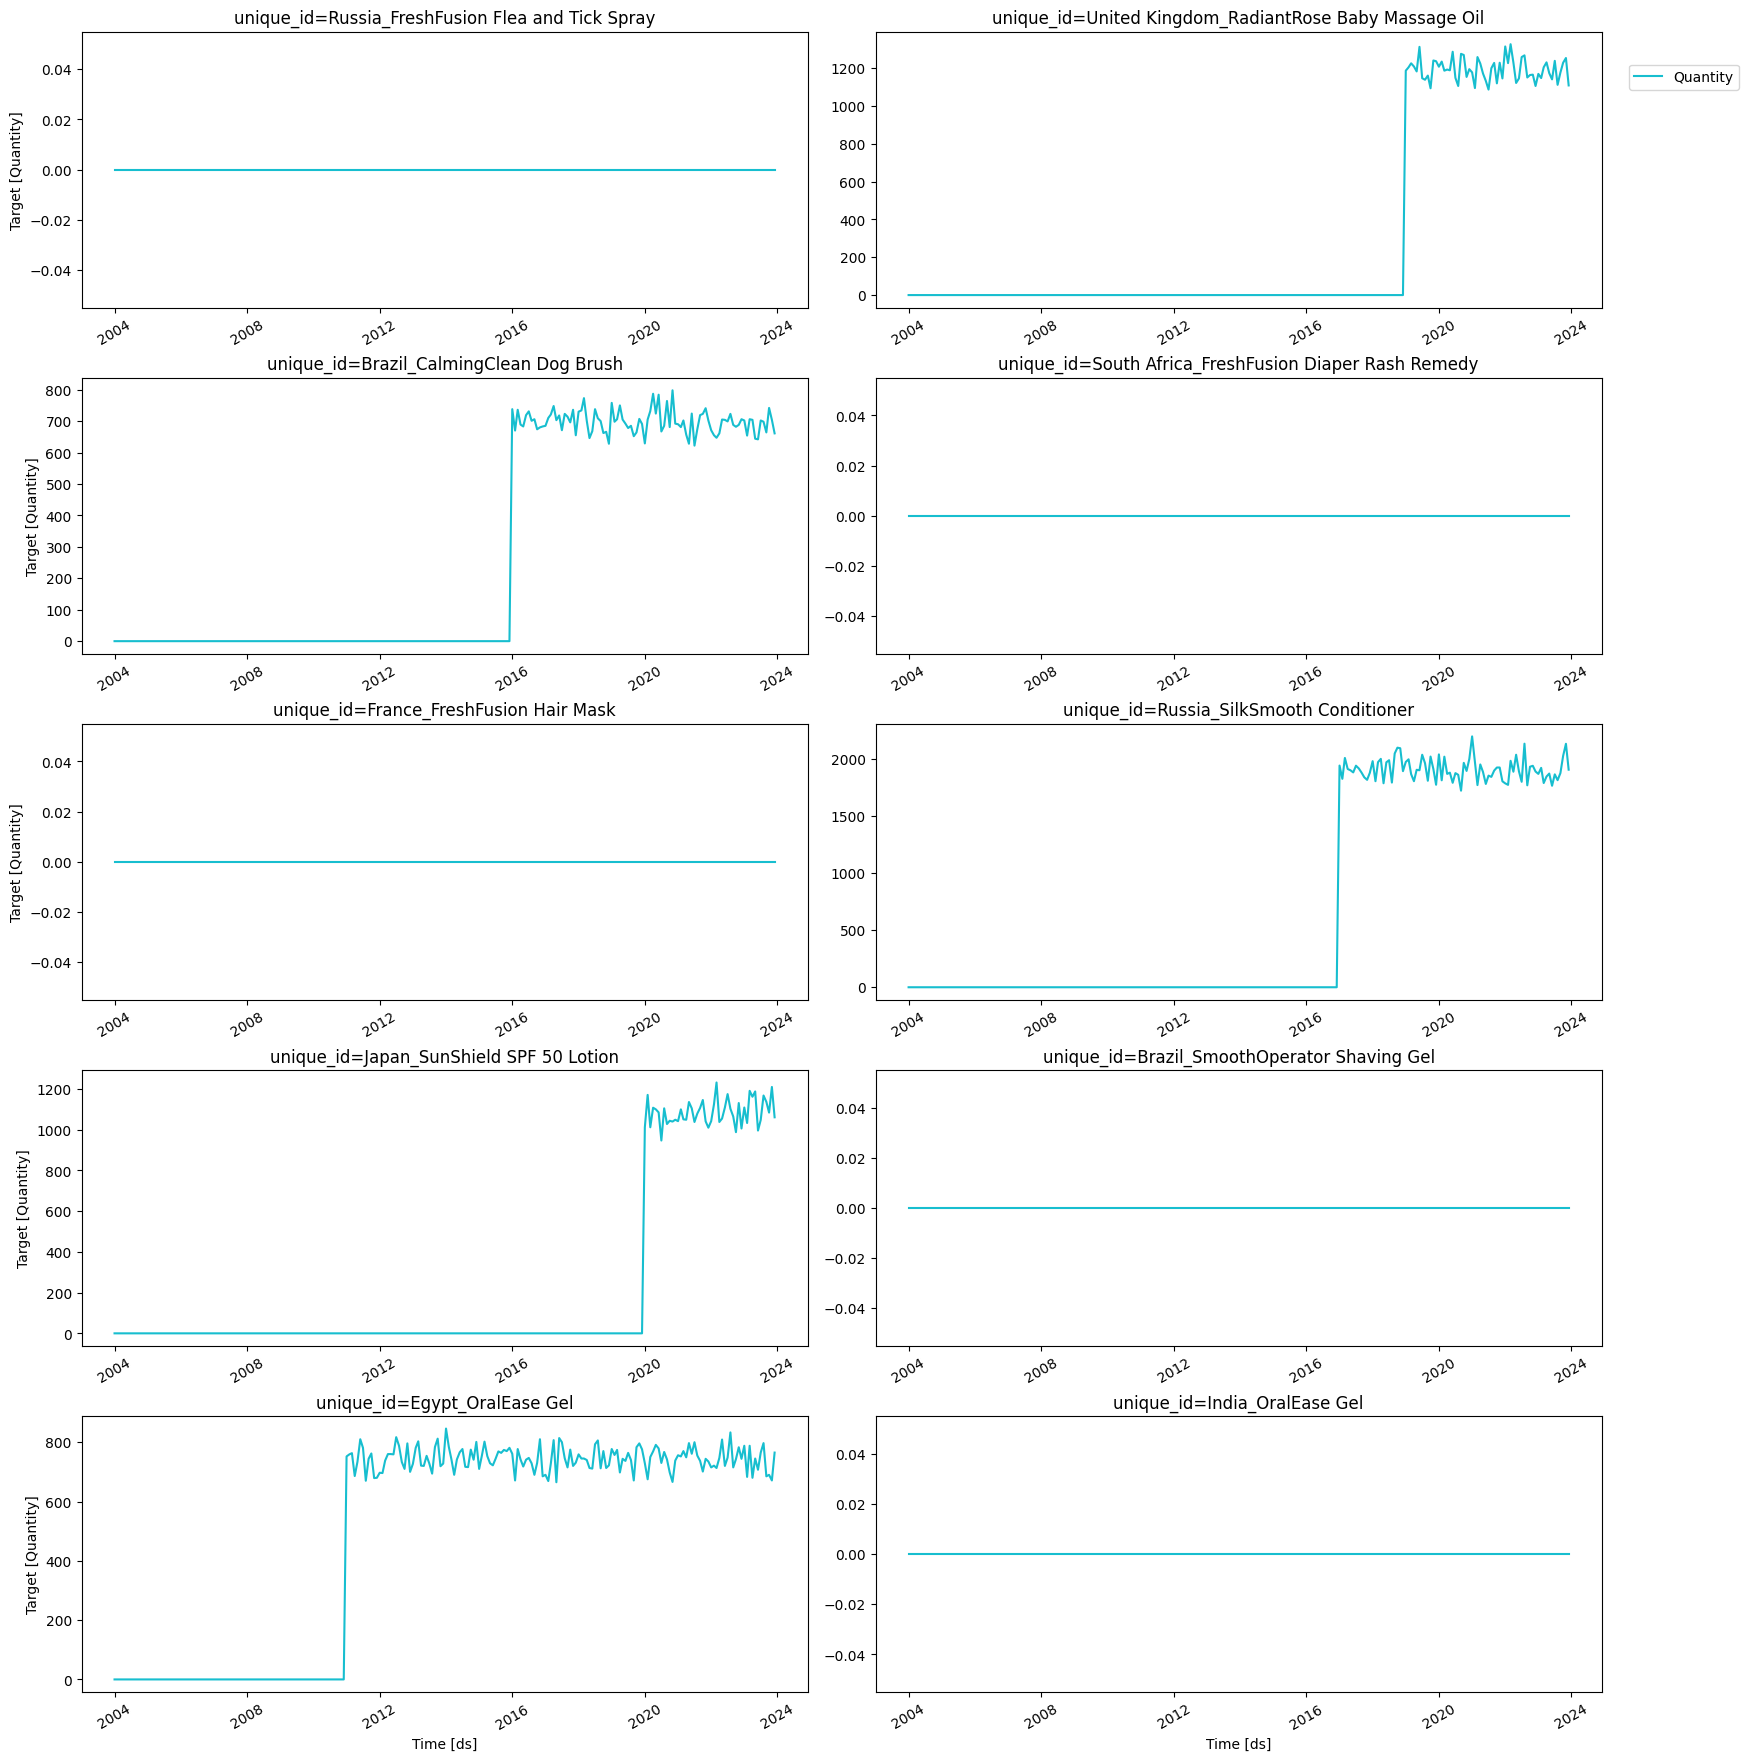

In [ ]:
from utilsforecast.plotting import plot_series
plot_series(df = df, target_col='Quantity',max_ids=10)

In [25]:
# Modeling
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM #DeepAR,NHITS,RNN,
from neuralforecast.utils import generate_series

In [53]:
series = generate_series(
    n_series= 100,
    freq= 'M',
    min_length=240,
    max_length= 240,
    n_temporal_features= 2
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralforecast/utils.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("2000-01-01", periods=max_length, freq=freq).values


In [54]:
series

,unique_id,ds,y,temporal_0,temporal_1
0,0,2000-01-31,8.506609,49,49
1,0,2000-02-29,42.085435,49,49
2,0,2000-03-31,71.342832,49,49
3,0,2000-04-30,101.445689,49,49
4,0,2000-05-31,130.566649,49,49
...,...,...,...,...,...
23995,99,2019-08-31,101.754790,23,23
23996,99,2019-09-30,117.003254,23,23
23997,99,2019-10-31,128.824357,23,23
23998,99,2019-11-30,143.226265,23,23


In [55]:
FORECASTING_HORIZON = 12 # one year ahead forecast

In [56]:
nf = NeuralForecast(
    models=[
        # Model 1: Long-short term memory
        LSTM(
            h =FORECASTING_HORIZON,
            input_size= FORECASTING_HORIZON*3,
            encoder_n_layers = 3,
            encoder_hidden_size= 64,
            decoder_hidden_size=  128,
            decoder_layers= 2,
            futr_exog_list = ['temporal_0','temporal_1'],#['month'],
            #stat_exog_list = ['Product','Country'],
            batch_size = 128,
            learning_rate= 5e-4,
            max_steps = 2000,         
        )
        # Model 2: 
        
    ],
    freq='ME',
)

Seed set to 1


In [57]:
import torch as th
th.device('cpu')

device(type='cpu')

In [58]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "0"

In [59]:
nf.fit(
    df = series,
    static_df= None,
    val_size= 12
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 84.2 K | train
4 | mlp_decoder  | MLP           | 8.7 K  | train
-------------------------------------------------------
92.9 K    Trainable params
0         Non-trainable params
92.9 K    Total params
0.372     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


NotImplementedError: The operator 'aten::nanmedian.dim_values' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.